In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')

In [2]:
train_data = pd.read_csv('../data/aps_failure_training_set.csv', skiprows=20)
test_data = pd.read_csv('../data/aps_failure_test_set.csv', skiprows=20)

In [3]:
pd.set_option("display.width", 300)
pd.set_option("display.max_columns", 15)
pd.set_option("display.float_format", "{:.2f}".format)  # Limit decimal places
print(train_data.info())
print(train_data.head())
print(train_data.dtypes)
print(test_data.info())
print(test_data.head())
print(test_data.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 171 entries, class to eg_000
dtypes: int64(1), object(170)
memory usage: 78.3+ MB
None
  class  aa_000 ab_000      ac_000 ad_000 ae_000 af_000  ...  ee_005  ee_006  ee_007  ee_008 ee_009 ef_000 eg_000
0   neg   76698     na  2130706438    280      0      0  ...  469792  339156  157956   73224      0      0      0
1   neg   33058     na           0     na      0      0  ...  245416  133654   81140   97576   1500      0      0
2   neg   41040     na         228    100      0      0  ...  409564  320746  158022   95128    514      0      0
3   neg      12      0          70     66      0     10  ...      44      10       0       0      0      4     32
4   neg   60874     na        1368    458      0      0  ...  347188  286954  311560  433954   1218      0      0

[5 rows x 171 columns]
class     object
aa_000     int64
ab_000    object
ac_000    object
ad_000    object
           ...  
ee_007    object
e

1B)I) DATA IMPUTATION
-

Step 1: Replace 'na' with np.nan, which is the standard missing value marker in numerical computations.
This is necessary because tools like SimpleImputer and statistical functions only understand np.nan, not 'na' strings.

Step 2: Separate features and labels. Check number of missing values before imputation

Step 3: Impute Missing values using simple mean imputation. Check for number of missing values after imputation

In [4]:
## Step 1: Replace 'na' with np.nan and convert all values to numeric
train_data.replace('na', np.nan, inplace=True)
test_data.replace('na', np.nan, inplace=True)

train_data.iloc[:, 1:] = train_data.iloc[:, 1:].apply(pd.to_numeric)
test_data.iloc[:, 1:] = test_data.iloc[:, 1:].apply(pd.to_numeric)

## Step 2: Separate features and labels
X_train = train_data.drop('class', axis=1)
y_train = train_data['class'].map({'neg': 0, 'pos': 1})

X_test = test_data.drop('class', axis=1)
y_test = test_data['class'].map({'neg': 0, 'pos': 1})

print("Train missing values before imputation:", X_train.isnull().sum().sum())
print("Test missing values before imputation:", X_test.isnull().sum().sum())

## Step 3: Impute Missing Values
# Use mean imputation; fit on training set only
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)

X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

#Quick Check for Missing Values
print("Train missing values after imputation:", X_train_imputed.isnull().sum().sum())
print("Test missing values after imputation:", X_test_imputed.isnull().sum().sum())

Train missing values before imputation: 850015
Test missing values before imputation: 228680
Train missing values after imputation: 0
Test missing values after imputation: 0


1B)II) Coefficient of Variation.
-

Note: Based on Piazza post (https://piazza.com/class/m5v7utcziq53q4/post/550), I used only training set for this. 

In [5]:
cv_values = X_train_imputed.std() / X_train_imputed.mean()
cv_sorted = cv_values.sort_values(ascending=False)

print("Top 10 features with highest Coefficient of Variation:")
print(cv_sorted.head(10))

Top 10 features with highest Coefficient of Variation:
cs_009   235.28
cf_000   184.23
co_000   183.95
ad_000   183.85
dh_000   114.98
dj_000   109.65
ag_000    91.88
as_000    86.42
ay_009    83.79
az_009    76.97
dtype: float64


1B)III) Correlation Matrix
-
Note: Followed the instructor endorsed answer here to display correlation matrix since the heatmap was too large and illegible. https://piazza.com/class/m5v7utcziq53q4/post/537

In [6]:
correlation_matrix = X_train_imputed.corr()
pd.set_option('display.max_rows', 170)
pd.set_option('display.max_columns', 170)
correlation_matrix.style\
    .format("{:.2f}")\
    .background_gradient(cmap='coolwarm')

C:\Users\navya\anaconda3\Lib\site-packages\pandas\io\formats\style.py:3807: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(gmap) if vmin is None else vmin
C:\Users\navya\anaconda3\Lib\site-packages\pandas\io\formats\style.py:3808: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(gmap) if vmax is None else vmax


1B)IV) Scatter Plots and Box Plots for High CV Features
-



Step 1: Select subset of top CV features

Step 2: Since it took a long time to generate plots with a large number of data points, I selected 1000 points from training set for plotting purposes. Refer to this Piazza post: https://piazza.com/class/m5v7utcziq53q4/post/542

Step 3: Pairplot

Step 4: Box plots 

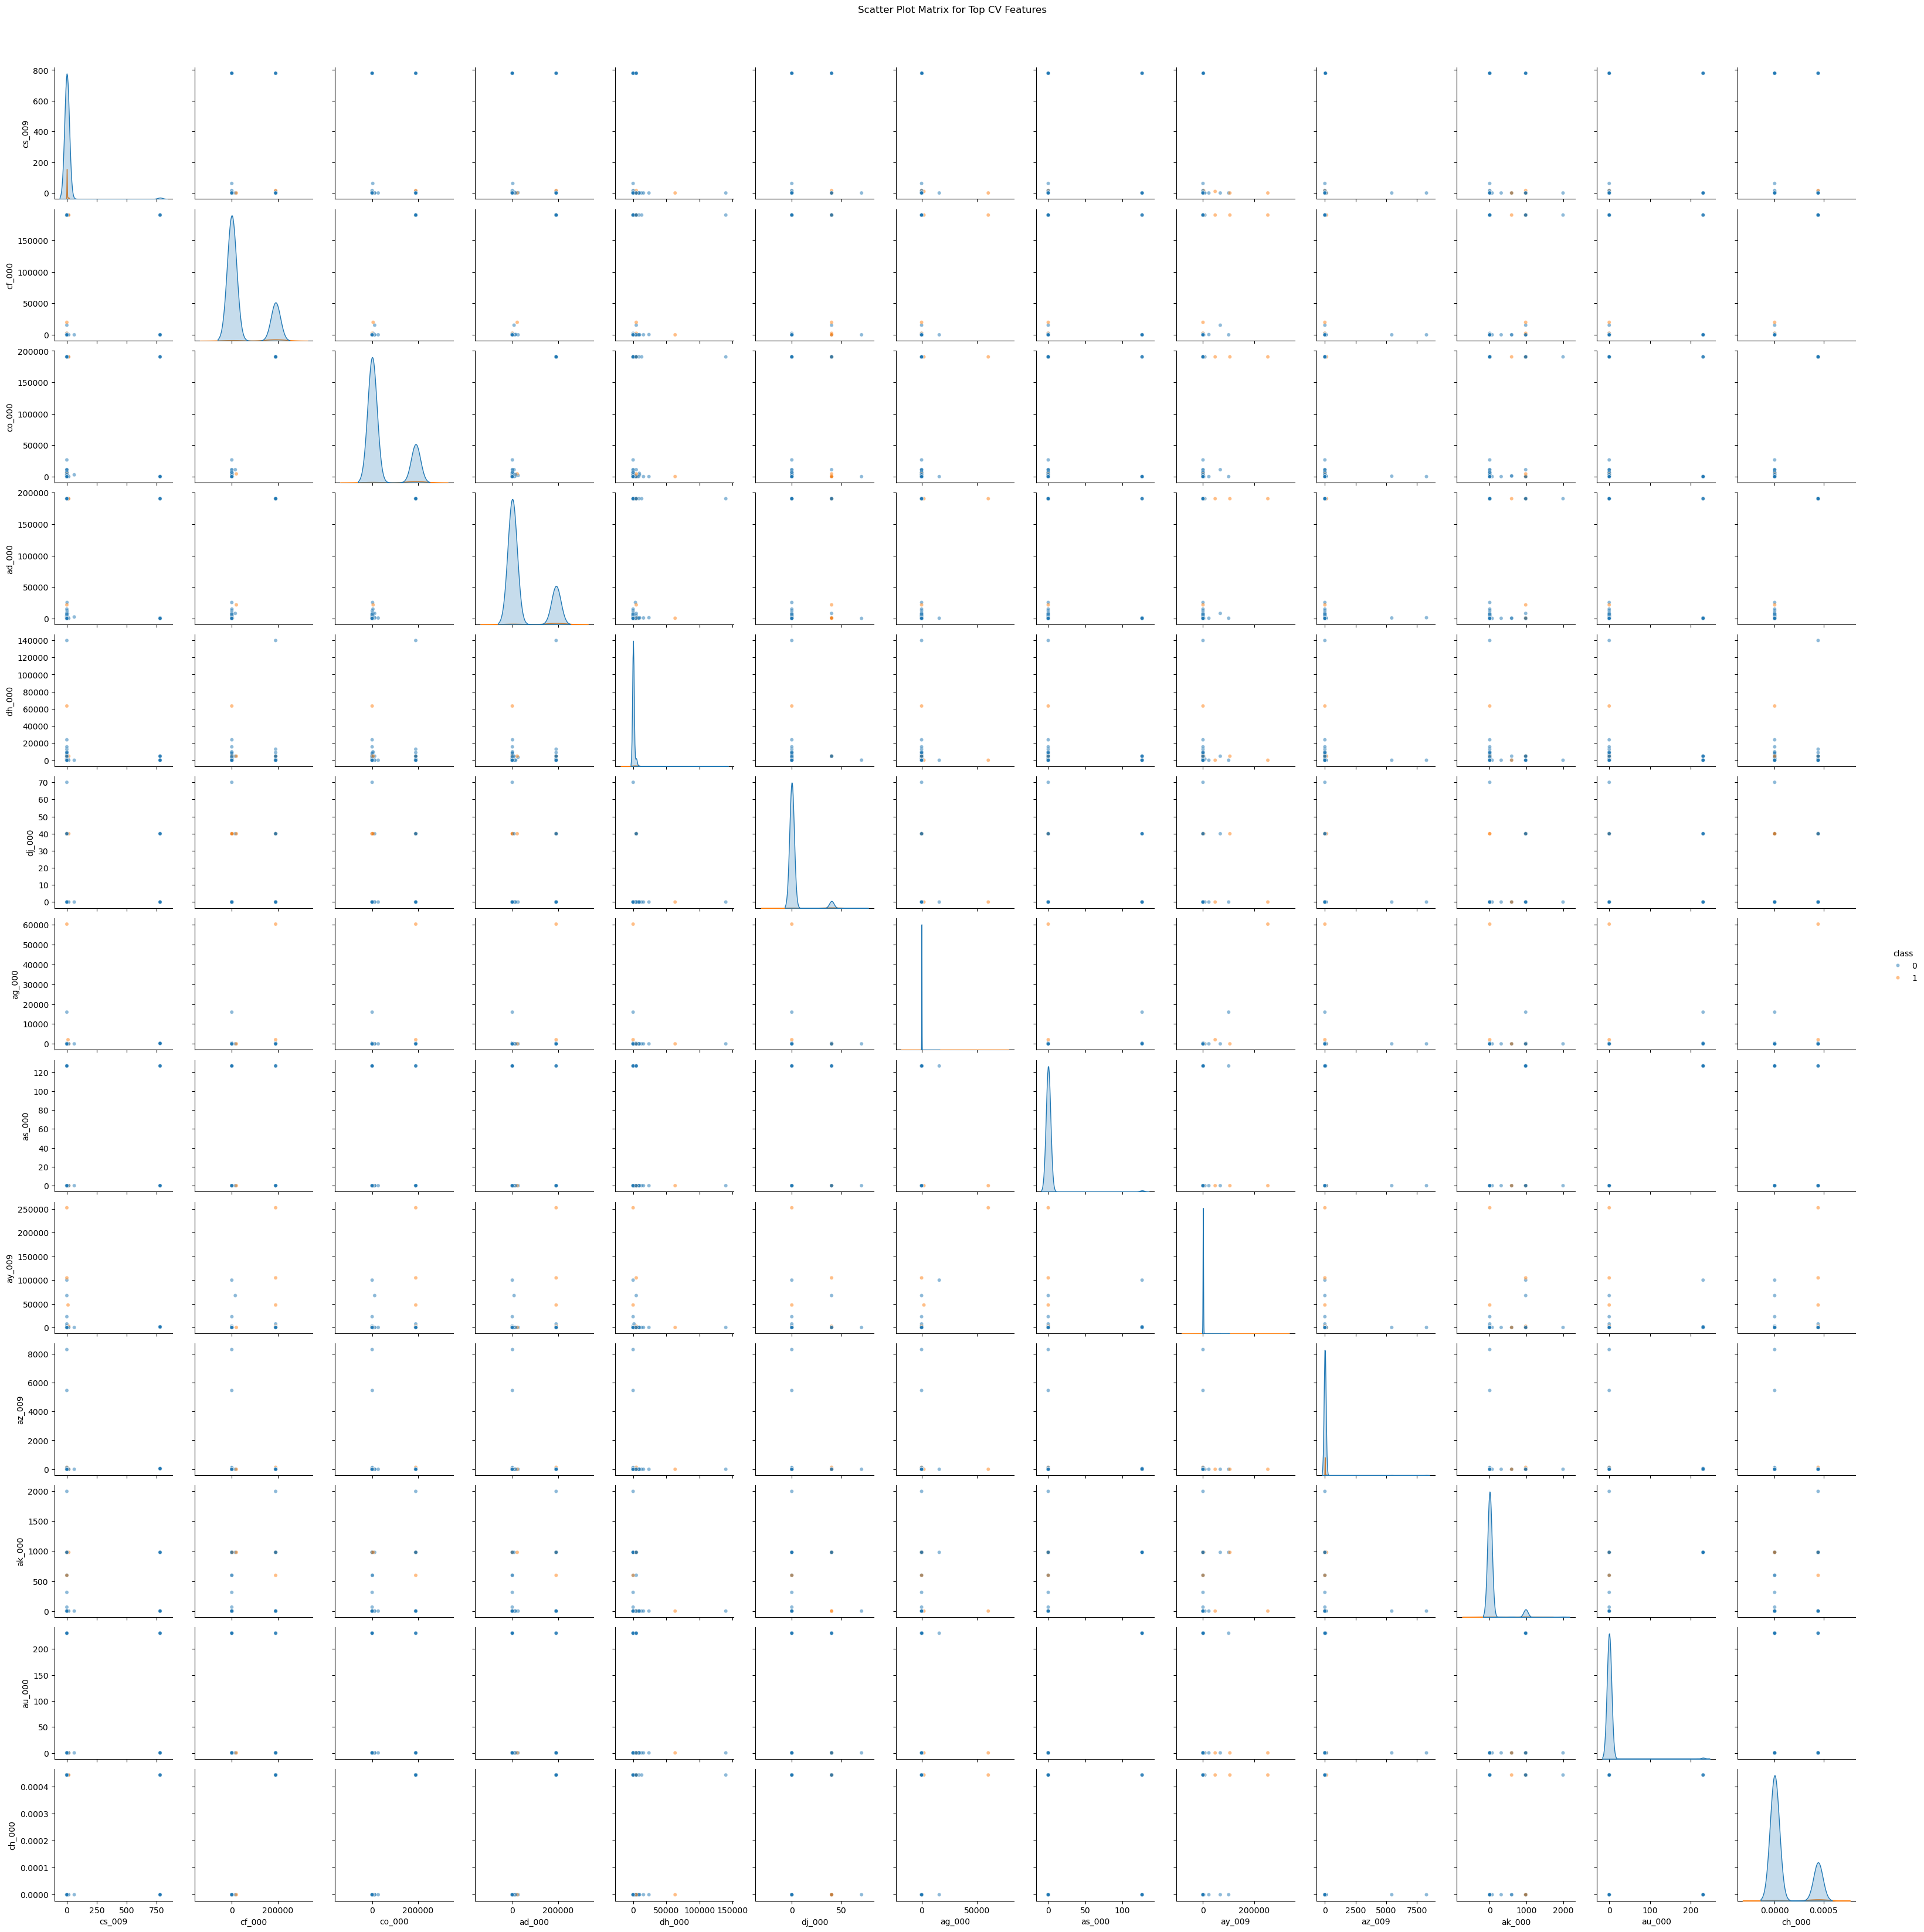

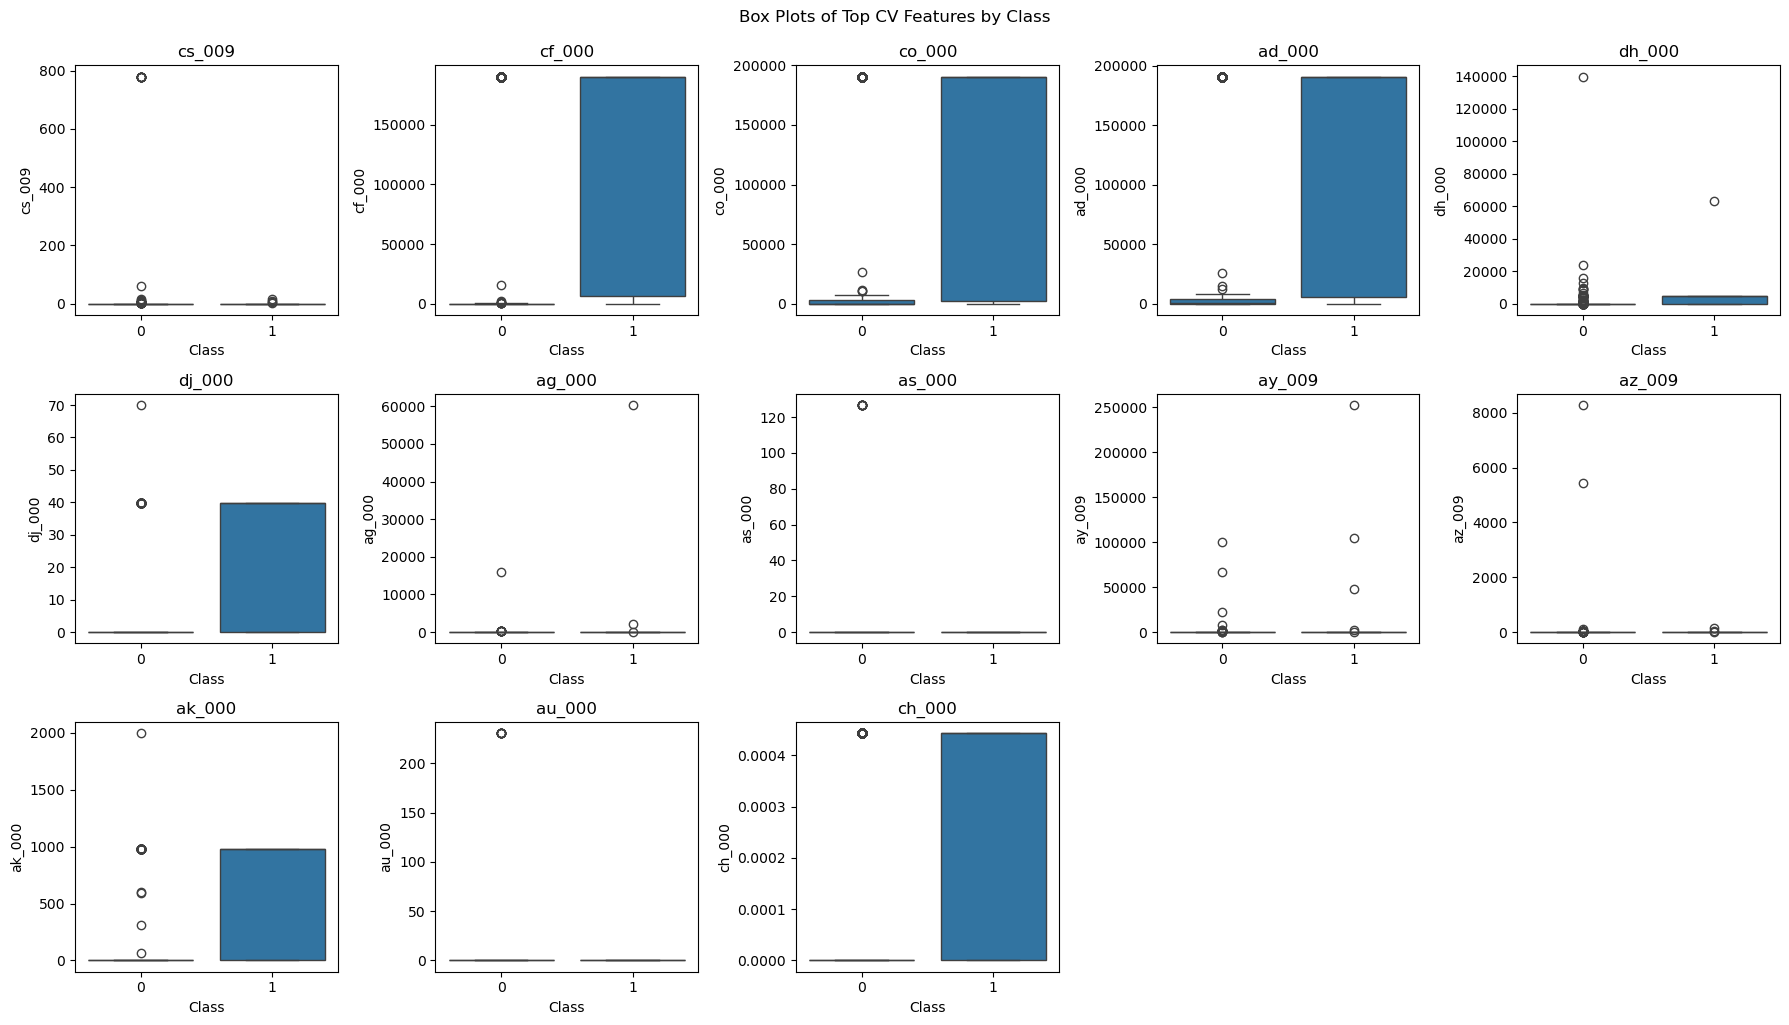

In [7]:
#Step 1: Select subset of top CV features 
num_features = int(math.floor(math.sqrt(170)))
top_cv_features = cv_sorted.head(num_features).index.tolist()

#Step 2: Sample 1000 points from training set for plotting
sampled_df = X_train_imputed.copy()
sampled_df['class'] = y_train
sampled_df_sample = sampled_df.sample(n=1000, random_state=42)

# Step 3: Pairplot (scatter plot matrix)
sns.pairplot(sampled_df_sample[top_cv_features + ['class']], hue='class', plot_kws={'alpha': 0.5, 's': 20})
plt.suptitle("Scatter Plot Matrix for Top CV Features", y=1.02)
plt.show()

# Step 4: Box plots for each top CV feature
plt.figure(figsize=(18, 10))
for idx, feature in enumerate(top_cv_features):
    plt.subplot(3, 5, idx + 1)
    sns.boxplot(x='class', y=feature, data=sampled_df_sample)
    plt.title(feature)
    plt.xlabel('Class')
    plt.tight_layout()

plt.suptitle("Box Plots of Top CV Features by Class", y=1.02)
plt.show()

1B) V) Number of positive and negative data
-

In [8]:
# Check class distribution in training data
class_counts = y_train.value_counts()
print("Class distribution in training data:")
print(class_counts)

neg_count = class_counts.get(0, 0)
pos_count = class_counts.get(1, 0)
imbalance_ratio = pos_count / (neg_count + pos_count)
print(f"\nPositive class ratio: {imbalance_ratio:.4f}")

# Check class distribution in test data
test_class_counts = y_test.value_counts()
print("\nClass distribution in test data:")
print(test_class_counts)

test_neg_count = test_class_counts.get(0, 0)
test_pos_count = test_class_counts.get(1, 0)
test_imbalance_ratio = test_pos_count / (test_neg_count + test_pos_count)
print(f"\nPositive class ratio (test): {test_imbalance_ratio:.4f}")

Class distribution in training data:
class
0    59000
1     1000
Name: count, dtype: int64

Positive class ratio: 0.0167

Class distribution in test data:
class
0    15625
1      375
Name: count, dtype: int64

Positive class ratio (test): 0.0234


Conclusion: Class is severely imbalanced. Source: Class lecture notes: 0-5%: severely imbalanced. 
-

1C) Random Forest:
--

We will create a function for modularity so we can pass multiple models and return the ROC, AUC, Confusion Matrices. 

In [9]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    y_train_proba = model.predict_proba(X_train)[:, 1]
    y_test_proba = model.predict_proba(X_test)[:, 1]

    train_cm = confusion_matrix(y_train, y_train_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)

    train_auc = roc_auc_score(y_train, y_train_proba)
    test_auc = roc_auc_score(y_test, y_test_proba)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_misclassification = 1 - train_acc
    test_misclassification = 1 - test_acc

    print(f"\n[{model_name}] Confusion Matrix - Train:")
    print(train_cm)
    print(f"\n[{model_name}] Confusion Matrix - Test:")
    print(test_cm)

    print(f"\nAUC - Train: {train_auc:.4f}")
    print(f"AUC - Test: {test_auc:.4f}")

    print(f"\nMisclassification Rate - Train: {train_misclassification:.4f}")
    print(f"Misclassification Rate - Test: {test_misclassification:.4f}")

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)

    plt.figure(figsize=(10, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC (AUC = {train_auc:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC (AUC = {test_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Out-of-Bag Error Estimate: 0.0060

[Random Forest (Uncompensated)] Confusion Matrix - Train:
[[59000     0]
 [    1   999]]

[Random Forest (Uncompensated)] Confusion Matrix - Test:
[[15609    16]
 [  107   268]]

AUC - Train: 1.0000
AUC - Test: 0.9942

Misclassification Rate - Train: 0.0000
Misclassification Rate - Test: 0.0077


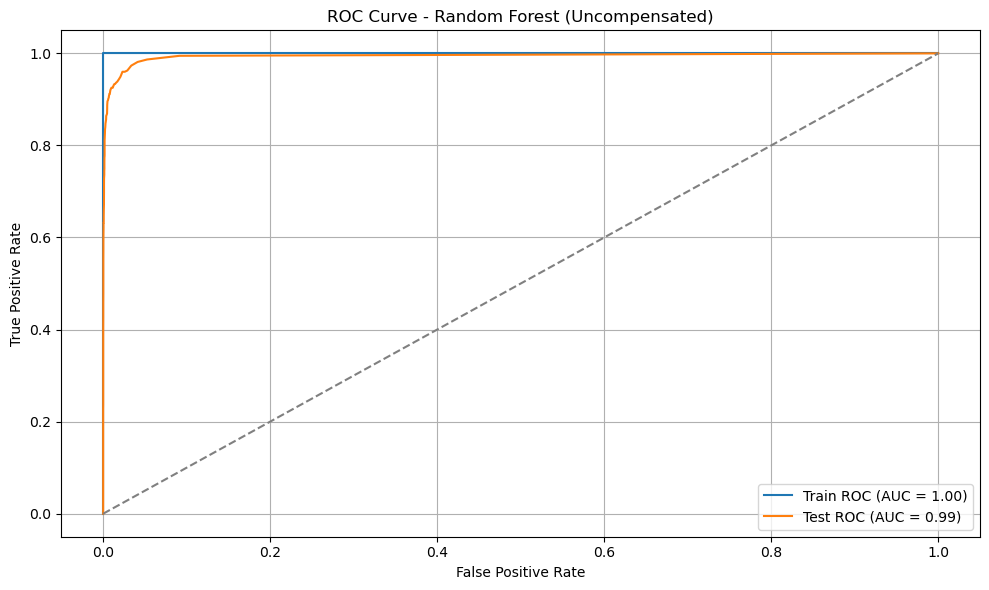

In [10]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42, n_jobs=-1)
rf.fit(X_train_imputed, y_train)
print(f"Out-of-Bag Error Estimate: {1 - rf.oob_score_:.4f}")
evaluate_model(rf, X_train_imputed, y_train, X_test_imputed, y_test, model_name="Random Forest (Uncompensated)")


1D) Adjusting for Class Imbalance: 
--
I have used class_weight='balanced' to automatically adjust weights inversely proportional to class frequencies.

What it does: It changes the way the model calculates split criteria during training:

It assigns more weight to the minority class during training. 

It adjusts the cost of misclassifying a minority sample to be higher, making the classifier more sensitive to it.

weight_class_i = total_samples / (n_classes * count_class_i)

Out-of-Bag Error Estimate (Balanced): 0.0077

[Random Forest (Balanced)] Confusion Matrix - Train:
[[59000     0]
 [    1   999]]

[Random Forest (Balanced)] Confusion Matrix - Test:
[[15613    12]
 [  166   209]]

AUC - Train: 1.0000
AUC - Test: 0.9865

Misclassification Rate - Train: 0.0000
Misclassification Rate - Test: 0.0111


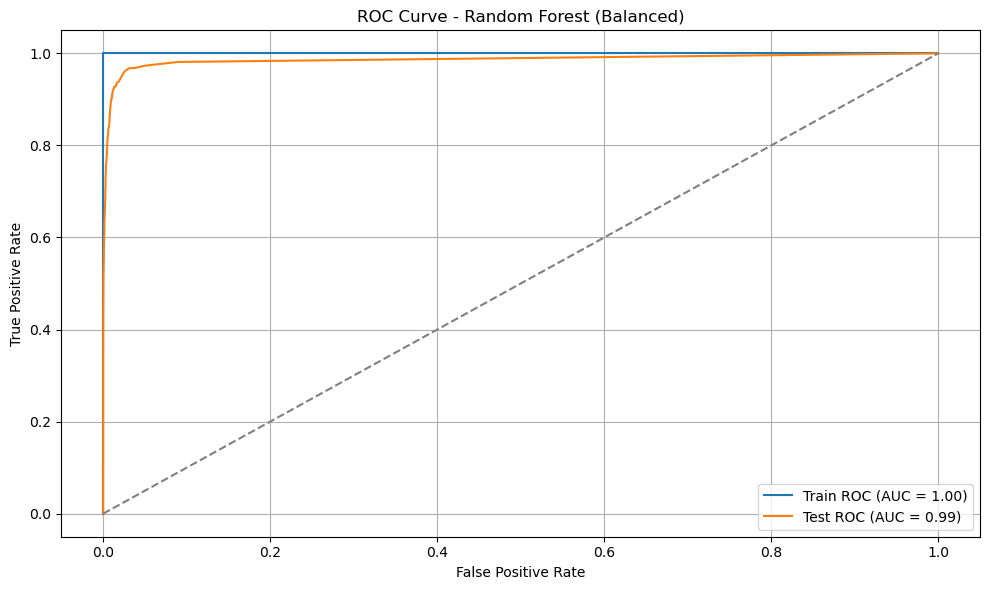

In [11]:
rf_balanced = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=42, n_jobs=-1, class_weight='balanced')
rf_balanced.fit(X_train_imputed, y_train)
print(f"Out-of-Bag Error Estimate (Balanced): {1 - rf_balanced.oob_score_:.4f}")
evaluate_model(rf_balanced, X_train_imputed, y_train, X_test_imputed, y_test, model_name="Random Forest (Balanced)")


Note that using balanced, we create more bias in our results as test error slightly increases
-

1E) XGBoost: Steps and Considerations:
--
Step 1: Define grid of possible alpha values 

Step 2: Set up XGBoost Classifier. 
Parameter choices:
- objective='binary:logistic': We are solving a binary classification problem. This setting applies logistic regression loss.
- eval_metric='logloss': A commonly used evaluation metric for binary classification problems.
- max_depth=3: Restricts the depth of each decision tree. Shallower trees help reduce overfitting and make the model more generalizable.
- learning_rate=0.1: Controls how much each new tree influences the model. Lower values (like 0.1) make training more stable.
- n_estimators=100: Limits the total number of trees (boosting rounds). A moderate number that balances performance and training time.
- reg_lambda=1: Applies L2 regularization to weights to avoid overfitting.

Step 3: Run 5-fold cross validation using GridSearchCV to find the best alpha based on ROC and AUC.

<u> **We use ROC AUC as the scoring metric during cross-validation because it is robust to class imbalance.** </u>

If we used accuracy, it could be misleading in imbalanced datasets by favoring the majority class and ignoring the performance on the minority class. e.g., model that predicts everything as negative still gets 98% accuracy.

ROC AUC evaluates how well the model ranks positive instances higher than negative ones, regardless of class imbalance.

**Step 4: Retrain XGBoost using the best alpha on the entire training set so we are not underfit. **

Step 5: Evaluate model. 


Fitting 5 folds for each of 6 candidates, totalling 30 fits

Best alpha from CV: 0.1

[XGBoost (Uncompensated)] Confusion Matrix - Train:
[[58951    49]
 [  228   772]]

[XGBoost (Uncompensated)] Confusion Matrix - Test:
[[15603    22]
 [  114   261]]

AUC - Train: 0.9960
AUC - Test: 0.9959

Misclassification Rate - Train: 0.0046
Misclassification Rate - Test: 0.0085


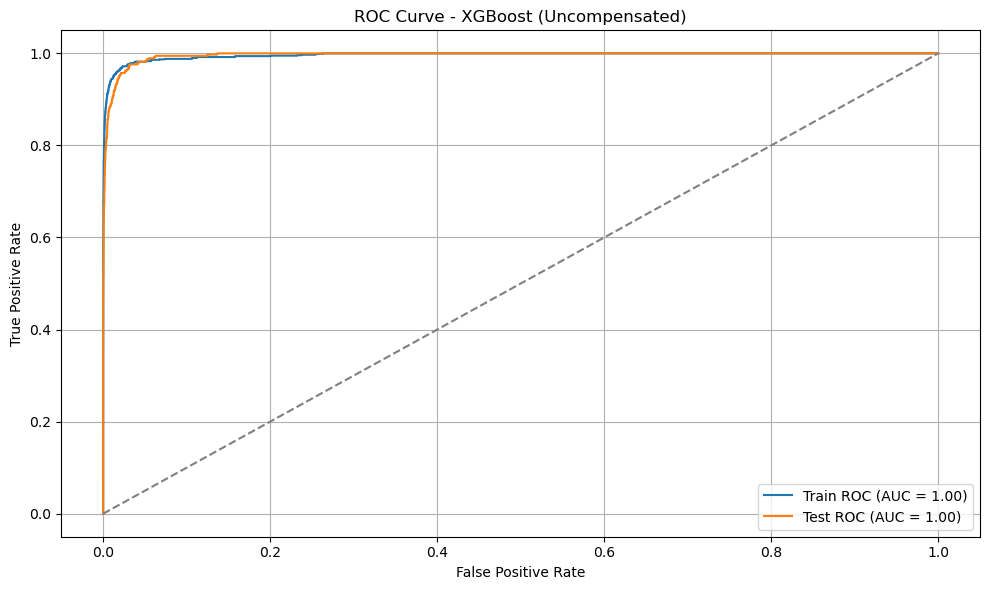

In [12]:


#Step 1: Grid of alpha values
param_grid = {
    'alpha': [0, 0.01, 0.1, 1, 10,100]  
}

#Step 2: Set up XGBoost
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)

#Step 3: Run 5-fold cross validation using GridSearchCV to find the best alpha based on ROC and AUC. 
#Refer to markdown cell above to see explanation
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='roc_auc', cv=5, verbose=1)
grid_search.fit(X_train_imputed, y_train)

print(f"\nBest alpha from CV: {grid_search.best_params_['alpha']}")

#Step 4: Retrain XGBoost using the best alpha on entire training set. 
best_alpha = grid_search.best_params_['alpha']
xgb_final = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    reg_alpha=best_alpha,  # Apply the selected L1 regularization
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)

#Step 5: Evaluate model
xgb_final.fit(X_train_imputed, y_train)
evaluate_model(xgb_final, X_train_imputed, y_train, X_test_imputed, y_test, model_name="XGBoost (Uncompensated)")

1F) XGBoost with SMOTE
--
**Step 1**: Set up SMOTE with Cross-Validation.

I used StratifiedKFold (with shuffling and fixed seed) to maintain class balance and ensure reproducibility.

**To properly use SMOTE in cross-validation without leakage, we apply SMOTE *within* each fold (after train/val split).**

We shoud NOT apply SMOTE to the validation fold or the entire dataset before CV.

This avoids data leakage and gives a more accurate estimate of generalization.

For each fold:

a) The training and validation data are split.

b) SMOTE is applied only to the training fold to generate synthetic minority samples.

c) The validation fold is left untouched.

d) XGBoost is trained on the resampled training fold and evaluated on the original validation fold using AUC.

The average AUC across folds is computed for each alpha (L1 regularization strength).

From the cross-validation results, the alpha with the highest average AUC is selected as the best regularization strength.

**Note**: In 1E, we used GridSearchCV directly on the original imbalanced training data because no sampling or resampling like SMOTE was involved, so there was no risk of data leakage. 
The data was split into folds, and each fold was kept completely natural. In 1F, using SMOTE introduces synthetic data points, which must be created after each training/validation split to avoid leaking synthetic samples into validation sets. 
Since GridSearchCV does not natively support this kind of fold-specific sampling, we needed to manually implement the cross-validation loop to apply SMOTE only on the training folds.
Step 2: Retrain on Full SMOTE-Resampled Training Set
SMOTE is applied once to the entire original training set (not test).

A final XGBoost model is trained on this SMOTE-resampled data using the best alpha from cross-validation.

Step 3: Evaluate on Original Test Set

Alpha: 0, CV AUC: 0.9850
Alpha: 0.01, CV AUC: 0.9852
Alpha: 0.1, CV AUC: 0.9848
Alpha: 1, CV AUC: 0.9855
Alpha: 10, CV AUC: 0.9854
Alpha: 100, CV AUC: 0.9850

Best alpha from SMOTE CV: 1

[XGBoost (SMOTE)] Confusion Matrix - Train:
[[57965  1035]
 [  595 58405]]

[XGBoost (SMOTE)] Confusion Matrix - Test:
[[15364   261]
 [   37   338]]

AUC - Train: 0.9991
AUC - Test: 0.9938

Misclassification Rate - Train: 0.0138
Misclassification Rate - Test: 0.0186


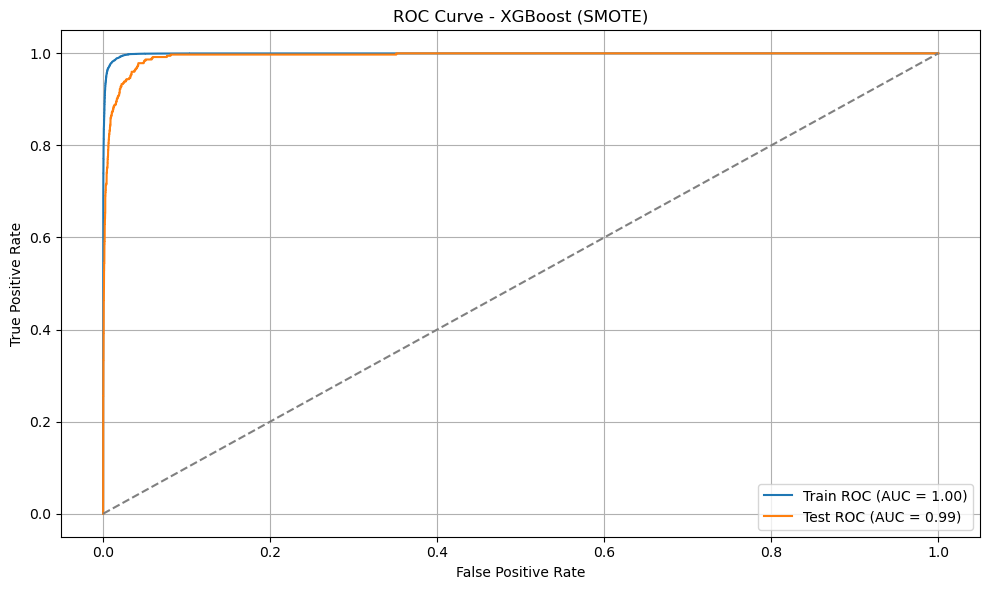

In [13]:
# Step 1: SMOTE Cross-Validation Setup
# To properly use SMOTE in cross-validation without leakage, we apply SMOTE *within* each fold (after train/val split).
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'alpha': [0, 0.01, 0.1, 1, 10, 100]  
}

best_auc = 0
best_alpha = None

# Manually cross-validate to apply SMOTE within each fold
#In 1E, we used GridSearchCV directly on the original imbalanced training data because no sampling or resampling like SMOTE was involved, 
#so there was no risk of data leakage. The data was split into folds, and each fold was kept completely natural. 
#In 1F, using SMOTE introduces synthetic data points, which must be created after each training/validation split 
#to avoid leaking synthetic samples into validation sets. 
#Since GridSearchCV does not natively support this kind of fold-specific sampling,
#we needed to manually implement the cross-validation loop to apply SMOTE only on the training folds — ensuring correctness.
for alpha in param_grid['alpha']:
    aucs = []
    for train_idx, val_idx in skf.split(X_train_imputed, y_train):
        X_train_fold, X_val_fold = X_train_imputed.iloc[train_idx], X_train_imputed.iloc[val_idx]
        y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # Apply SMOTE to training fold only
        smote = SMOTE(random_state=42)
        X_train_res, y_train_res = smote.fit_resample(X_train_fold, y_train_fold)

        model = xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss',
            max_depth=3,
            learning_rate=0.1,
            n_estimators=100,
            reg_alpha=alpha,
            reg_lambda=1,
            random_state=42,
            n_jobs=-1
        )

        model.fit(X_train_res, y_train_res)
        y_val_proba = model.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_val_proba)
        aucs.append(auc)

    avg_auc = np.mean(aucs)
    print(f"Alpha: {alpha}, CV AUC: {avg_auc:.4f}")
    if avg_auc > best_auc:
        best_auc = avg_auc
        best_alpha = alpha

print(f"\nBest alpha from SMOTE CV: {best_alpha}")


# Step 2: Retrain XGBoost on full SMOTE-balanced data using best alpha
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_imputed, y_train)

xgb_smote = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    reg_alpha=best_alpha,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1
)

xgb_smote.fit(X_train_smote, y_train_smote)


# Step 3: Evaluate SMOTE Model
evaluate_model(xgb_smote, X_train_smote, y_train_smote, X_test_imputed, y_test, model_name="XGBoost (SMOTE)")


Note to Grader: Q2-5 are saved in PDF file inside the notebook folder of the repository. 
-

Sources / References:

https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

https://www.analyticsvidhya.com/blog/2022/10/handling-missing-data-with-simpleimputer/

https://xgboost.readthedocs.io/en/release_3.0.0/

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://www.datacamp.com/tutorial/random-forests-classifier-python

https://abookishwolf.medium.com/dealing-with-class-imbalance-in-a-random-forest-classifier-e97c406f693d

https://stackoverflow.com/questions/58275113/proper-use-of-class-weight-parameter-in-random-forest-classifier

https://www.datacamp.com/tutorial/xgboost-in-python

Google / chatgpt prompts:

1.	What are the different data imputation techniques on Python? How to implement them? 

2.	How does python know which ones are missing values? 

3.	How to use isnull to check for missing values? 

4.	How to count the number of missing values in dataset? 

5.	How to change list to sorted ? 

6.	How to print a correlation matrix with a background gradient? 

7.	From my sorted list of features by CV, how do I select a subset of them to a list? 

8.	How to generate box plot for each feature using a for loop?

9.	How to generate count of number of positive and negative class data using value_counts()

10.	How to calculate class imbalance ratio?

11.	How to fit a random forest model with OOB score? 

12.	How to get ROC, AUC, Confusion Matrix for Random Forest?

13.	How to get accuracy score and misclassification rates for random forest classifier? 

14.	For Random Forest model, how to adjust for class imbalance?

15.	What does class_weight = ‘balanced’ do? 

16.	How to fit XGboost? How to find alpha using cross validation? What are the different parameters in XGboost? 

17.	How to use SMOTE along with XGBoost? 

18.	How to manually implement cross validation to select best lpha using XGBoost and SMOTE? 

19.	How to apply SMOTE within each fold to find the best alpha? How to loop through all the alpha
